# 한글설정

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothicCoding')

# 데이터 가져오기

In [2]:
import os
import gdown

id = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
output = "./open.zip"

if not os.path.isdir('./datasets'):
  gdown.download(id=id, output=output)
  gdown.extractall(path=output, to='./datasets')

# 데이터프레임 만들기

In [3]:
import os
import glob
import pandas as pd
from collections import defaultdict

raw_data = defaultdict(pd.DataFrame)

for fname in glob.glob('./**/*.csv', recursive=True):
    df_name = os.path.splitext(os.path.basename(fname))[0]
    raw_data[df_name] = pd.read_csv(fname)

# Feature Selection
* SelectFromModel을 이용하여 Feature 갯수를 줄여나가야함.
* 1개부터 cross_val_score로 검증
* 그래프도 그려보자

In [5]:
# train 데이터
train = raw_data['train'].copy()

In [6]:
# X_04, X_23, X_47, X_48 은 값이 1개라서 제외
train = train.drop(columns=['X_04', 'X_23', 'X_47', 'X_48']).copy()

## SelectFromModel 파이프라인
* https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel
* 가중치 때문에 2개의 파이프라인이 필요함.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor


In [ ]:

pipe = Pipeline([
  ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1))),
  ('classification', RandomForestRegressor(n_estimators=200, n_jobs=-1))
])


In [8]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'feature_selection', 'classification', 'feature_selection__estimator__bootstrap', 'feature_selection__estimator__ccp_alpha', 'feature_selection__estimator__criterion', 'feature_selection__estimator__max_depth', 'feature_selection__estimator__max_features', 'feature_selection__estimator__max_leaf_nodes', 'feature_selection__estimator__max_samples', 'feature_selection__estimator__min_impurity_decrease', 'feature_selection__estimator__min_samples_leaf', 'feature_selection__estimator__min_samples_split', 'feature_selection__estimator__min_weight_fraction_leaf', 'feature_selection__estimator__n_estimators', 'feature_selection__estimator__n_jobs', 'feature_selection__estimator__oob_score', 'feature_selection__estimator__random_state', 'feature_selection__estimator__verbose', 'feature_selection__estimator__warm_start', 'feature_selection__estimator', 'feature_selection__importance_getter', 'feature_selection__max_features', 'feature_selection__norm_ord

## 커스텀 스코어 함수 생성
* 데이콘에서 제공한 스코어 함수 사용

In [5]:
import numpy as np
from sklearn import metrics

# 데이콘에서 제공한 평가함수
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

## Kfold 객체 생성

In [6]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=13)

## 데이터 분리

In [11]:
X = train.filter(regex='X')
y = train.filter(regex='Y')

## GridSearchCV 수행
* https://gijopeter.medium.com/cross-validation-for-ml-feature-selection-ffdb71e5a68f

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [ ]:

hyper_params = [{'feature_selection__max_features': list(range(5, 30))}]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False), verbose=3)
model_cv.fit(X.values, y.values)

# 결과분석 1

- 최적의 Feature 갯수는 16 
- 컬럼 리스트 : ['X_03', 'X_05', 'X_07', 'X_08', 'X_09', 'X_19', 'X_21', 'X_22', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56']

In [31]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,89.005584,0.696025,3.982254,0.100392,5,{'feature_selection__max_features': 5},-2.011415,-2.002772,-2.011416,-1.979278,-1.980358,-1.997048,0.014422,25
1,91.760918,0.809481,4.121449,0.062774,6,{'feature_selection__max_features': 6},-2.006728,-1.993520,-2.009130,-1.962979,-1.978608,-1.990193,0.017424,24
2,93.872671,0.862336,4.299526,0.060731,7,{'feature_selection__max_features': 7},-1.999100,-1.994815,-2.007776,-1.961504,-1.975900,-1.987819,0.016787,23
3,95.273341,0.294701,4.288559,0.064370,8,{'feature_selection__max_features': 8},-1.974724,-1.976523,-2.000368,-1.954130,-1.962363,-1.973621,0.015695,20
4,98.119632,1.079937,4.379281,0.045690,9,{'feature_selection__max_features': 9},-1.996165,-1.975475,-1.998012,-1.963874,-1.978739,-1.982453,0.012944,22


In [34]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_feature_selection__max_features', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

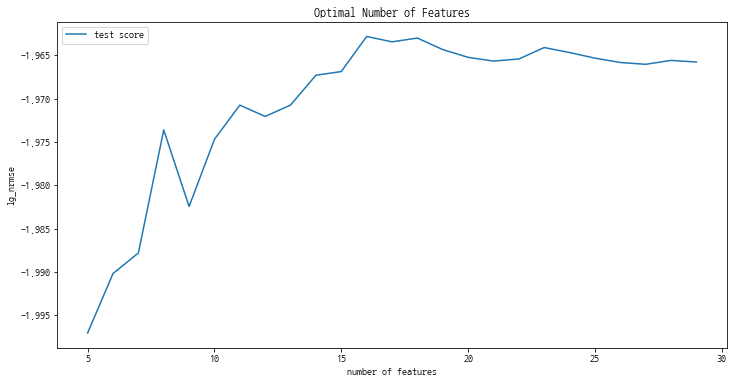

In [46]:
plt.figure(figsize=(12,6))
plt.plot(cv_results['param_feature_selection__max_features'], cv_results['mean_test_score'])
# plt.plot(cv_results['param_feature_selection__max_features'], cv_results['mean_train_score'])
plt.xlabel('number of features')
plt.ylabel('lg_nrmse')
plt.title('Optimal Number of Features')
plt.legend(['test score', 'train score'], loc='upper left')
plt.show()

In [36]:
print(model_cv.best_params_)

{'feature_selection__max_features': 16}


In [42]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns[selector.get_support()]

Index(['X_03', 'X_05', 'X_07', 'X_08', 'X_09', 'X_19', 'X_21', 'X_22', 'X_49',
       'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
      dtype='object')

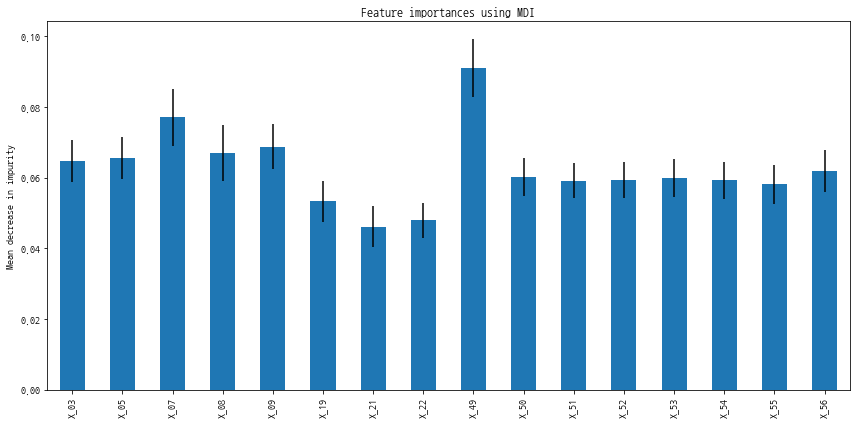

In [45]:
model = model_cv.best_estimator_['classification']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns[selector.get_support()])

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()



- 'X_49'가 중요한 Feature라고 확인됨.
- 값을 확인해보니 값이 크고 히스토그램상 왼쪽으로 치우친 모습을 보임.
- log1p -> StandardScaler 적용하기로 함

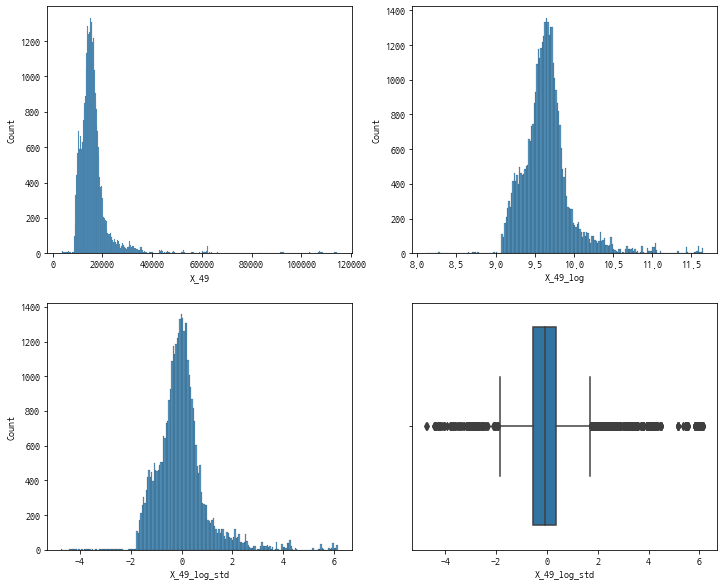

In [17]:
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

def display_scaler_plot(cname):
  fig, ax = plt.subplots(2, 2, figsize=(12, 10))

  data = train[[cname]].copy()

  sns.histplot(x=cname, data=data, ax=ax[0][0])

  ft = FunctionTransformer(np.log1p)
  data[cname+'_log'] = ft.fit_transform(data[cname])

  sns.histplot(x=cname+'_log', data=data, ax=ax[0][1])

  ss = StandardScaler()
  data[cname+'_log_std'] = ss.fit_transform(data[cname+'_log'].values.reshape(-1, 1))

  sns.histplot(x=cname+'_log_std', data=data, ax=ax[1][0])
  sns.boxplot(x=cname+'_log_std', data=data, ax=ax[1][1])

  plt.show()

display_scaler_plot('X_49')

In [15]:
# log1p -> StandardScaler 파이프라인
log_std_transformer = Pipeline(
        steps=[
            ("log1p", FunctionTransformer(np.log1p))
          , ("std", StandardScaler())]
    )

In [13]:
# 컬럼 인덱스 함수
def column_index(X, column):
    for i, v in enumerate(X.columns):
        if v == column:
            return i

column_index(X, 'X_49')

40

In [31]:
len(X.columns)

52

In [39]:
lst_cols = []
lst_cols.append(column_index(X, 'X_49'))

In [40]:
none_cols = set(X.columns) - set(['X_49'])

In [41]:

none_cols = [column_index(X, v) for v in sorted(none_cols)]
none_cols[:2], len(none_cols)

([0, 1], 51)

In [16]:
from sklearn.compose import ColumnTransformer

# 컬럼별 전처리 분류기
preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("none", 'passthrough', none_cols)
      ]
    )

NameError: name 'log_std_transformer' is not defined

In [38]:
# 전처리를 파이프라인 앞에 위치시킴.
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=200, n_jobs=-1))
])

In [21]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'feature_selection', 'regression', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__verbose_feature_names_out', 'preprocessing__lst', 'preprocessing__none', 'preprocessing__lst__memory', 'preprocessing__lst__steps', 'preprocessing__lst__verbose', 'preprocessing__lst__log1p', 'preprocessing__lst__std', 'preprocessing__lst__log1p__accept_sparse', 'preprocessing__lst__log1p__check_inverse', 'preprocessing__lst__log1p__func', 'preprocessing__lst__log1p__inv_kw_args', 'preprocessing__lst__log1p__inverse_func', 'preprocessing__lst__log1p__kw_args', 'preprocessing__lst__log1p__validate', 'preprocessing__lst__std__copy', 'preprocessing__lst__std__with_mean', 'preprocessing__lst__std__with_std', 'feature_selection__estimator__bootstrap', 'feature_selection__estimator__ccp_alpha', 'feature_s

In [37]:
# 앞선 결과에서 16개 일때 가장 좋은 결과를 얻었으므로 테스트 범위는 16 +/-2
# max_depth도 변화를 주기로 함.

hyper_params = [{
    'feature_selection__max_features': [20]
    , 'feature_selection__estimator__max_depth': [30]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        ,return_train_score=True, verbose=3, n_jobs=2)
model_cv.fit(X.values, y.values)

ValueError: Parameter grid for parameter (feature_selection__max_features) needs to be a list or numpy array, but got (<class 'int'>). Single values need to be wrapped in a list with one element.

In [29]:
model_cv.best_score_

-1.9626072848631568

In [30]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns[selector.get_support()]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 52 but corresponding boolean dimension is 53

* 컴퓨터 리소스가 부족해서 매번 GridSearchCV를 활용하기 어려움. 다음 테스트 부터는 방법을 전환하기로 함

In [44]:
lst_cols = []
lst_cols.append(column_index(X, 'X_49'))

std_cols = set(X.columns) - set(['X_49'])
std_cols = [column_index(X, v) for v in sorted(std_cols)]

preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("std", StandardScaler(), std_cols)
      ]
    )

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=250, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=250, max_depth=30 n_jobs=-1))
])

hyper_params = [{
    'feature_selection__max_features': [20]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        ,return_train_score=True, verbose=3)
model_cv.fit(X.values, y.values)                        

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END feature_selection__estimator__max_depth=30, feature_selection__max_features=20;, score=(train=-0.728, test=-1.968) total time= 2.4min
[CV 2/5] END feature_selection__estimator__max_depth=30, feature_selection__max_features=20;, score=(train=-0.727, test=-1.966) total time= 2.3min
[CV 3/5] END feature_selection__estimator__max_depth=30, feature_selection__max_features=20;, score=(train=-0.726, test=-1.984) total time= 2.3min
[CV 4/5] END feature_selection__estimator__max_depth=30, feature_selection__max_features=20;, score=(train=-0.729, test=-1.946) total time= 2.3min
[CV 5/5] END feature_selection__estimator__max_depth=30, feature_selection__max_features=20;, score=(train=-0.729, test=-1.951) total time= 2.3min


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('lst',
                                                                         Pipeline(steps=[('log1p',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         [44]),
                                                                        ('std',
                                                                         StandardScaler(),
                                                                         [0, 1,
                         

In [48]:
base_score = model_cv.best_score_
base_score

-1.9628628666621832

In [47]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns = selected_columns[selector.get_support()]
len(selected_columns), selected_columns

(19,
 Index(['X_01', 'X_05', 'X_06', 'X_08', 'X_09', 'X_10', 'X_20', 'X_21', 'X_22',
        'X_24', 'X_35', 'X_38', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55',
        'X_56'],
       dtype='object'))

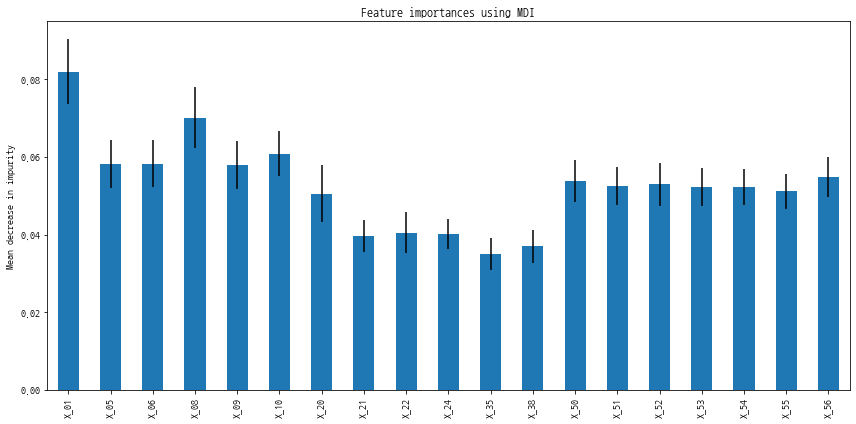

In [53]:
model = model_cv.best_estimator_['regression']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [54]:
# 유니크 값이 적고 데이터가 치우친 일부 컬럼을 제외하기로 함.
# X_02, X_10, X_11, X_46

train = raw_data['train'].drop(columns=['X_04', 'X_23', 'X_47', 'X_48', 'X_02', 'X_10', 'X_11', 'X_46']).copy()

X = train.filter(regex='X')
y = train.filter(regex='Y')



In [56]:
lst_cols = []
lst_cols.append(column_index(X, 'X_49'))

std_cols = set(X.columns) - set(['X_49'])
std_cols = [column_index(X, v) for v in sorted(std_cols)]

preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("std", StandardScaler(), std_cols)
      ]
    )

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=250, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=250, max_depth=30, n_jobs=-1))
])

hyper_params = [{
    'feature_selection__max_features': [20]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        ,return_train_score=True, verbose=3)
model_cv.fit(X.values, y.values)                        

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END feature_selection__max_features=20;, score=(train=-0.758, test=-1.967) total time= 2.4min
[CV 2/5] END feature_selection__max_features=20;, score=(train=-0.759, test=-1.966) total time= 2.4min
[CV 3/5] END feature_selection__max_features=20;, score=(train=-0.760, test=-1.986) total time= 2.4min
[CV 4/5] END feature_selection__max_features=20;, score=(train=-0.760, test=-1.943) total time= 2.4min
[CV 5/5] END feature_selection__max_features=20;, score=(train=-0.759, test=-1.949) total time= 2.4min


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('lst',
                                                                         Pipeline(steps=[('log1p',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         [40]),
                                                                        ('std',
                                                                         StandardScaler(),
                                                                         [0, 1,
                         

In [57]:
model_cv.best_score_

-1.962142413297585

In [58]:
if model_cv.best_score_ > base_score:
    print('base_score changed: {}'.format(model_cv.best_score_ - base_score))
    base_score = model_cv.best_score_

base_score changed: 0.0007204533645981392


In [59]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns = selected_columns[selector.get_support()]
len(selected_columns), selected_columns

(17,
 Index(['X_01', 'X_05', 'X_06', 'X_08', 'X_09', 'X_12', 'X_20', 'X_21', 'X_22',
        'X_24', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
       dtype='object'))

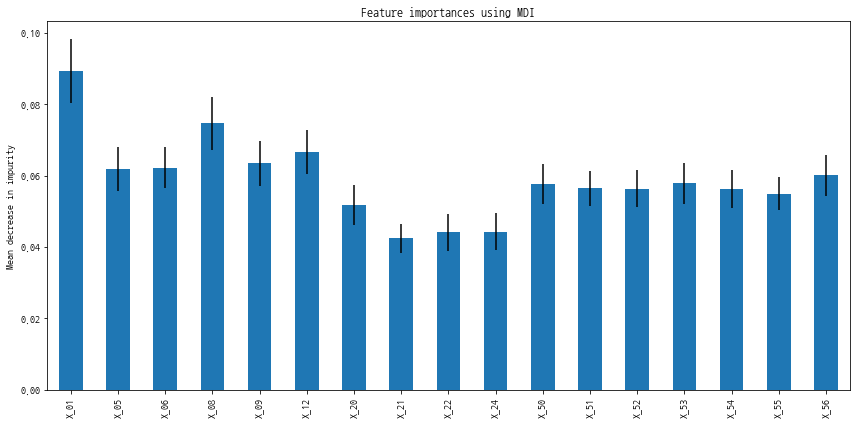

In [60]:
model = model_cv.best_estimator_['regression']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Feature X_38

Outlier count: 39189


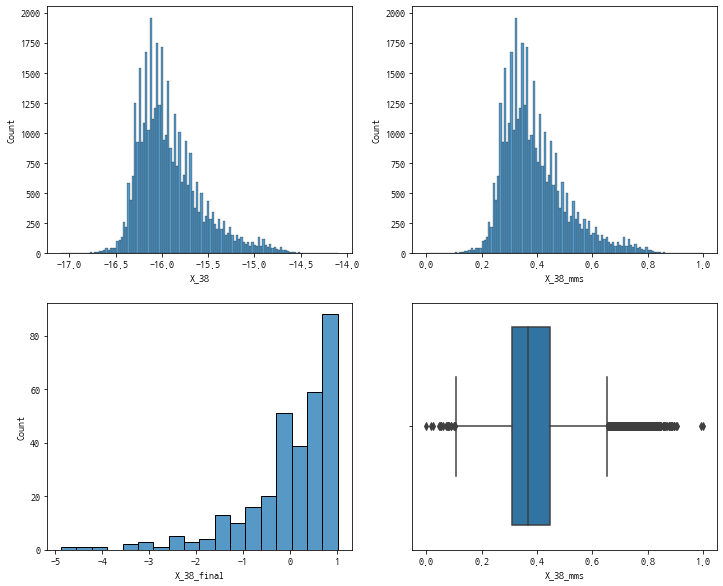

In [35]:
from sklearn.preprocessing import MinMaxScaler

def display_x38_plot(cname):
    data = train[[cname]].copy()
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    # 원본 히스토그램
    sns.histplot(x=cname, data=data, ax=ax[0][0])

    # MinMax 스케일러 적용
    mms = MinMaxScaler()
    data[cname+'_mms'] = mms.fit_transform(data[cname].values.reshape(-1, 1))
    sns.histplot(x=cname+'_mms', data=data, ax=ax[0][1])
    sns.boxplot(x=cname+'_mms', data=data, ax=ax[1][1])

    # 이상치 삭제 후 log1p -> StandardScaler적용
    split_line = 0.2
    print('Outlier count: {}'.format(data[data[cname+'_mms'] > split_line][cname].count()))
    data[cname+'_mms'] = data[data[cname+'_mms'] < split_line][cname+'_mms']
    ft = FunctionTransformer(np.log1p)
    ss = StandardScaler()
    data[cname+'_final'] = ft.fit_transform(data[cname+'_mms'])
    data[cname+'_final'] = ss.fit_transform(data[cname+'_final'].values.reshape(-1, 1))
    sns.histplot(x=cname+'_final', data=data, ax=ax[1][0])

    plt.show()

display_x38_plot('X_38')

In [10]:
def minmax_outlier_index(cname, weight):
    data = train[[cname]].copy()
    mms = MinMaxScaler()
    data[cname+'_mms'] = mms.fit_transform(data[cname].values.reshape(-1, 1))
    return data[data[cname+'_mms'] > weight].index

minmax_outlier_index(cname='X_38', weight=0.2)

Int64Index([ 1752,  4044,  4140,  6072,  6141,  6519,  8029,  8347,  8548,
             8734,  8831, 10584, 10709, 11596, 12995, 14471, 15392, 15503,
            19663, 19789, 19795, 23006, 23768, 23812, 24026, 24093, 24097,
            27813, 28278, 28388, 28468, 28618, 28662, 32272, 32397, 32547,
            35922, 36385, 36506, 36982, 37042],
           dtype='int64')

In [11]:
train = raw_data['train'].drop(columns=['X_04', 'X_23', 'X_47', 'X_48', 'X_02', 'X_10', 'X_11', 'X_46']).copy()

outlier_index = minmax_outlier_index(cname='X_38', weight=0.2)
train = train.drop(outlier_index, axis=0).copy()

In [14]:

X = train.filter(regex='X')
y = train.filter(regex='Y')

lst_cols = []
lst_cols.append(column_index(X, 'X_49'))

mlt_cols = []
mlt_cols.append(column_index(X, 'X_38'))

std_cols = set(X.columns) - set(['X_49']) - set(['X_38'])
std_cols = [column_index(X, v) for v in sorted(std_cols)]
len(X.columns), len(std_cols), len(lst_cols), len(mlt_cols)

(48, 46, 1, 1)

In [18]:

# log1p -> StandardScaler 파이프라인
log_std_transformer = Pipeline(
        steps=[
            ("log1p", FunctionTransformer(np.log1p))
          , ("std", StandardScaler())]
    )

# MinMax -> log1p -> StandardScaler 파이프라인
min_log_transformer = Pipeline(
        steps=[("minmax", MinMaxScaler())
        , ("log1p", FunctionTransformer(np.log1p))
        , ("std", StandardScaler())]
    )
    
preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("mlt", min_log_transformer, mlt_cols),
          ("std", StandardScaler(), std_cols)
      ]
    )

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=200, max_depth=20, n_jobs=-1))
])

hyper_params = [{
    'feature_selection__max_features': [20]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        ,return_train_score=True, verbose=3)
model_cv.fit(X.values, y.values)                        

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END feature_selection__max_features=20;, score=(train=-1.134, test=-1.948) total time= 1.8min
[CV 2/5] END feature_selection__max_features=20;, score=(train=-1.150, test=-1.936) total time= 1.7min
[CV 3/5] END feature_selection__max_features=20;, score=(train=-1.152, test=-1.962) total time= 1.8min
[CV 4/5] END feature_selection__max_features=20;, score=(train=-1.149, test=-1.977) total time= 1.8min
[CV 5/5] END feature_selection__max_features=20;, score=(train=-1.138, test=-1.998) total time= 1.8min


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('lst',
                                                                         Pipeline(steps=[('log1p',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         [40]),
                                                                        ('mlt',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMax

In [22]:
base_score = -1.962142413297585

In [20]:
model_cv.best_score_

-1.964203877017597

In [23]:
if model_cv.best_score_ > base_score:
    print('base_score changed: {}'.format(model_cv.best_score_ - base_score))
    base_score = model_cv.best_score_

In [24]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns = selected_columns[selector.get_support()]
len(selected_columns), selected_columns

(17,
 Index(['X_01', 'X_06', 'X_07', 'X_09', 'X_12', 'X_13', 'X_21', 'X_22', 'X_24',
        'X_25', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
       dtype='object'))

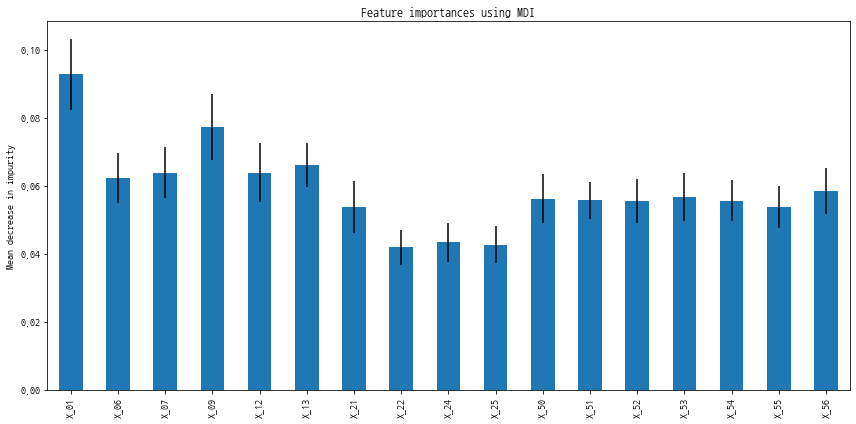

In [25]:
model = model_cv.best_estimator_['regression']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Feature: X_39

Outlier count: 60


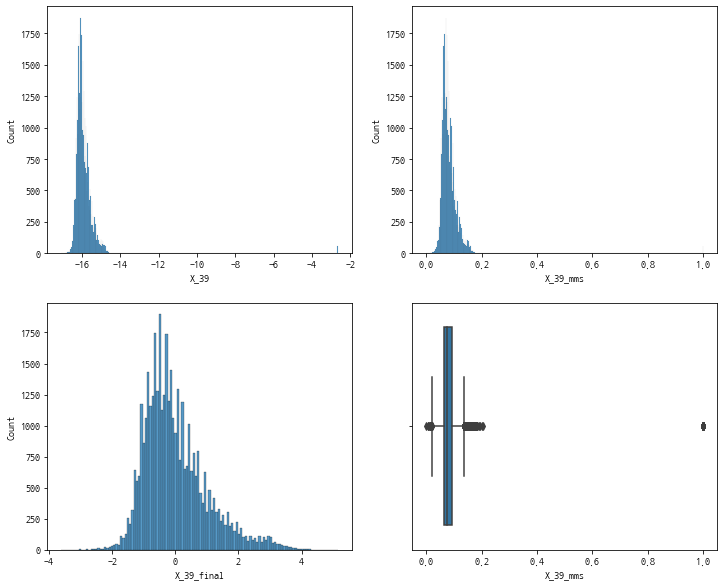

In [26]:
from sklearn.preprocessing import MinMaxScaler

def display_x38_plot(cname):
    data = train[[cname]].copy()
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    # 원본 히스토그램
    sns.histplot(x=cname, data=data, ax=ax[0][0])

    # MinMax 스케일러 적용
    mms = MinMaxScaler()
    data[cname+'_mms'] = mms.fit_transform(data[cname].values.reshape(-1, 1))
    sns.histplot(x=cname+'_mms', data=data, ax=ax[0][1])
    sns.boxplot(x=cname+'_mms', data=data, ax=ax[1][1])

    # 이상치 삭제 후 log1p -> StandardScaler적용
    split_line = 0.8
    print('Outlier count: {}'.format(data[data[cname+'_mms'] > split_line][cname].count()))
    data[cname+'_mms'] = data[data[cname+'_mms'] < split_line][cname+'_mms']
    ft = FunctionTransformer(np.log1p)
    ss = StandardScaler()
    data[cname+'_final'] = ft.fit_transform(data[cname+'_mms'])
    data[cname+'_final'] = ss.fit_transform(data[cname+'_final'].values.reshape(-1, 1))
    sns.histplot(x=cname+'_final', data=data, ax=ax[1][0])

    plt.show()

display_x38_plot('X_39')

In [27]:
train = raw_data['train'].drop(columns=['X_04', 'X_23', 'X_47', 'X_48', 'X_02', 'X_10', 'X_11', 'X_46']).copy()

outlier_index = []
outlier_index.extend(minmax_outlier_index(cname='X_38', weight=0.2))
outlier_index.extend(minmax_outlier_index(cname='X_39', weight=0.8))
train = train.drop(outlier_index, axis=0).copy()

In [29]:
X = train.filter(regex='X')
y = train.filter(regex='Y')

lst_cols = []
lst_cols.append(column_index(X, 'X_49'))

mlt_cols = []
mlt_cols.append(column_index(X, 'X_38'))
mlt_cols.append(column_index(X, 'X_39'))

std_cols = set(X.columns) - set(['X_49']) - set(['X_38', 'X_39'])
std_cols = [column_index(X, v) for v in sorted(std_cols)]
len(X.columns), len(std_cols), len(lst_cols), len(mlt_cols)

(48, 45, 1, 2)

In [30]:
# log1p -> StandardScaler 파이프라인
log_std_transformer = Pipeline(
        steps=[
            ("log1p", FunctionTransformer(np.log1p))
          , ("std", StandardScaler())]
    )

# MinMax -> log1p -> StandardScaler 파이프라인
min_log_transformer = Pipeline(
        steps=[("minmax", MinMaxScaler())
        , ("log1p", FunctionTransformer(np.log1p))
        , ("std", StandardScaler())]
    )
    
preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("mlt", min_log_transformer, mlt_cols),
          ("std", StandardScaler(), std_cols)
      ]
    )

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=200, max_depth=30, n_jobs=-1))
])

hyper_params = [{
    'feature_selection__max_features': [20]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        ,return_train_score=True, verbose=3)
model_cv.fit(X.values, y.values)                        

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END feature_selection__max_features=20;, score=(train=-0.754, test=-1.992) total time= 1.8min
[CV 2/5] END feature_selection__max_features=20;, score=(train=-0.756, test=-1.996) total time= 1.8min
[CV 3/5] END feature_selection__max_features=20;, score=(train=-0.765, test=-1.914) total time= 1.8min
[CV 4/5] END feature_selection__max_features=20;, score=(train=-0.762, test=-1.951) total time= 1.8min
[CV 5/5] END feature_selection__max_features=20;, score=(train=-0.761, test=-1.976) total time= 1.8min


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('lst',
                                                                         Pipeline(steps=[('log1p',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         [40]),
                                                                        ('mlt',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMax

In [31]:
model_cv.best_score_

-1.9658873645404438

In [32]:
if model_cv.best_score_ > base_score:
    print('base_score changed: {}'.format(model_cv.best_score_ - base_score))
    base_score = model_cv.best_score_

In [33]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns = selected_columns[selector.get_support()]
len(selected_columns), selected_columns

(17,
 Index(['X_01', 'X_07', 'X_08', 'X_12', 'X_13', 'X_14', 'X_22', 'X_24', 'X_25',
        'X_26', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
       dtype='object'))

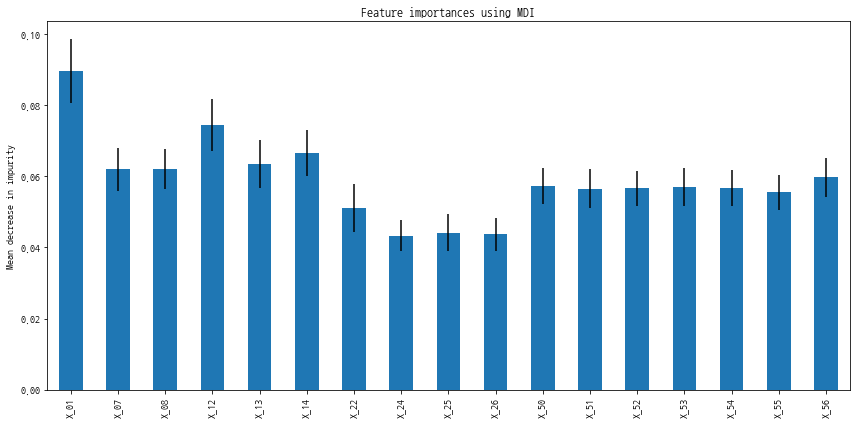

In [34]:
model = model_cv.best_estimator_['regression']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Feature: X_08

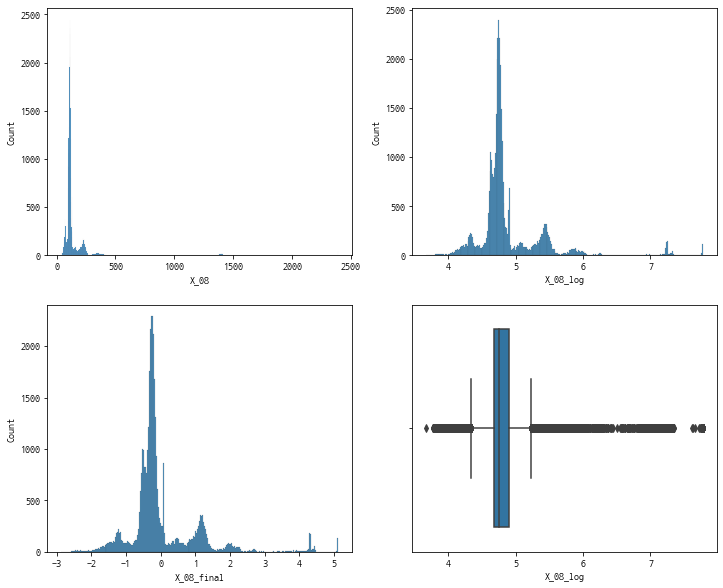

In [38]:
def display_x08_plot(cname):
    data = train[[cname]].copy()
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    # 원본 히스토그램
    ss = StandardScaler()
    sns.histplot(x=cname, data=data, ax=ax[0][0])

    # log1p 스케일러 적용
    ft = FunctionTransformer(np.log1p)
    data[cname+'_log'] = ft.fit_transform(data[cname])
    sns.histplot(x=cname+'_log', data=data, ax=ax[0][1])
    sns.boxplot(x=cname+'_log', data=data, ax=ax[1][1])

    # 이상치 삭제 후 StandardScaler적용
    # split_line = 0.95
    # print('Outlier count: {}'.format(data[data[cname+'_log'] > split_line][cname].count()))
    # data[cname+'_mms'] = data[data[cname+'_log'] < split_line][cname+'_log']
    
    data[cname+'_final'] = ft.fit_transform(data[cname+'_log'])
    data[cname+'_final'] = ss.fit_transform(data[cname+'_final'].values.reshape(-1, 1))
    sns.histplot(x=cname+'_final', data=data, ax=ax[1][0])

    plt.show()

display_x08_plot('X_08')

In [ ]:
train = raw_data['train'].drop(columns=['X_04', 'X_23', 'X_47', 'X_48', 'X_02', 'X_10', 'X_11', 'X_46']).copy()

outlier_index = []
outlier_index.extend(minmax_outlier_index(cname='X_38', weight=0.2))
outlier_index.extend(minmax_outlier_index(cname='X_39', weight=0.8))
train = train.drop(outlier_index, axis=0).copy()

In [39]:
X = train.filter(regex='X')
y = train.filter(regex='Y')

lst_cols = []
lst_cols.append(column_index(X, 'X_08'))
lst_cols.append(column_index(X, 'X_49'))

mlt_cols = []
mlt_cols.append(column_index(X, 'X_38'))
mlt_cols.append(column_index(X, 'X_39'))

std_cols = set(X.columns) - set(['X_08', 'X_49']) - set(['X_38', 'X_39'])
std_cols = [column_index(X, v) for v in sorted(std_cols)]
len(X.columns), len(std_cols), len(lst_cols), len(mlt_cols)

(48, 44, 2, 2)

In [40]:
# log1p -> StandardScaler 파이프라인
log_std_transformer = Pipeline(
        steps=[
            ("log1p", FunctionTransformer(np.log1p))
          , ("std", StandardScaler())]
    )

# MinMax -> log1p -> StandardScaler 파이프라인
min_log_transformer = Pipeline(
        steps=[("minmax", MinMaxScaler())
        , ("log1p", FunctionTransformer(np.log1p))
        , ("std", StandardScaler())]
    )
    
preprocessor = ColumnTransformer(
      transformers=[
          ("lst", log_std_transformer, lst_cols),
          ("mlt", min_log_transformer, mlt_cols),
          ("std", StandardScaler(), std_cols)
      ]
    )

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=200, n_jobs=-1))),
    ('regression', RandomForestRegressor(n_estimators=200, max_depth=30, n_jobs=-1))
])

hyper_params = [{
    'feature_selection__max_features': [20]
    }]

model_cv = GridSearchCV(pipe, hyper_params, cv=kfold, scoring=make_scorer(lg_nrmse, greater_is_better=False)
                        , verbose=3)
model_cv.fit(X.values, y.values)                        

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END feature_selection__max_features=20;, score=(train=-0.757, test=-1.987) total time= 1.9min
[CV 2/5] END feature_selection__max_features=20;, score=(train=-0.758, test=-1.996) total time= 1.8min
[CV 3/5] END feature_selection__max_features=20;, score=(train=-0.764, test=-1.916) total time= 1.8min
[CV 4/5] END feature_selection__max_features=20;, score=(train=-0.763, test=-1.951) total time= 1.8min
[CV 5/5] END feature_selection__max_features=20;, score=(train=-0.761, test=-1.976) total time= 1.8min


GridSearchCV(cv=KFold(n_splits=5, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('lst',
                                                                         Pipeline(steps=[('log1p',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         [5,
                                                                          40]),
                                                                        ('mlt',
                                                                         Pipeline(steps=[('minmax',
                   

In [41]:
model_cv.best_score_

-1.9651780402412726

In [42]:
if model_cv.best_score_ > base_score:
    print('base_score changed: {}'.format(model_cv.best_score_ - base_score))
    base_score = model_cv.best_score_

In [43]:
selector = model_cv.best_estimator_['feature_selection']

selected_columns = X.columns
selected_columns = selected_columns[selector.get_support()]
len(selected_columns), selected_columns

(18,
 Index(['X_01', 'X_03', 'X_08', 'X_09', 'X_13', 'X_14', 'X_22', 'X_24', 'X_25',
        'X_26', 'X_40', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56'],
       dtype='object'))

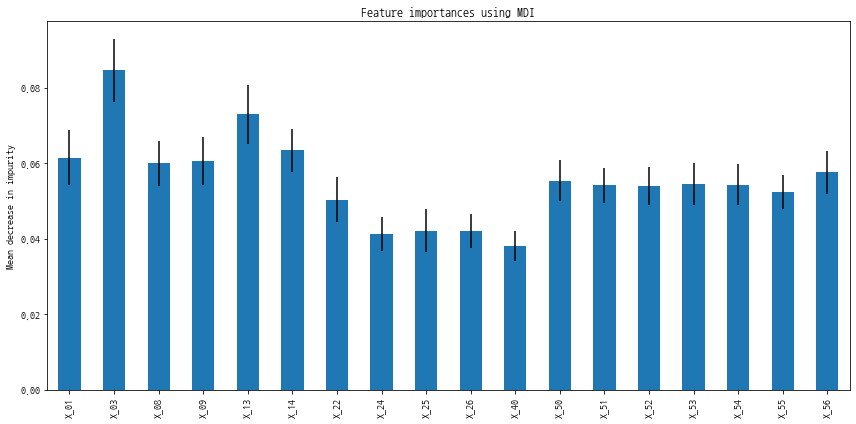

In [44]:
model = model_cv.best_estimator_['regression']

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=selected_columns)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [27]:
def get_outlier(df=None, column=None, weight=1.5, status='Error'):
    fraud = df[df['Status'] == status][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index

    return outlier_index

def remove_outlier(df, columns, status, weight, max_limit=40000):
    outlier_list = []

    for colname in columns: 
        outlier = get_outlier(df, colname, weight=weight, status=status)
        if len(outlier) > max_limit:
            continue
        outlier_list.extend(outlier)

    result = df.drop(outlier_list, axis=0).copy()

    return result

# 학습하기

In [82]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

scaler_list = [
    ('Unscaled', None),
    ('Standard', StandardScaler()),
    ('Min-Max', MinMaxScaler()),
    ('Min-Abs', MaxAbsScaler()),
    ('Robust', RobustScaler(quantile_range=(25, 75))),
    ('uniform pdf', QuantileTransformer(output_distribution="uniform")),
    ('gaussian pdf', QuantileTransformer(output_distribution="normal")),
    ('L2 normalizing', Normalizer())
]

In [83]:
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

def run_train(scaler=None):

  kf = KFold(shuffle=True, random_state=13)
  loss = []
  
  # 데이터 나누기
  X, y = train.filter(regex='X').values, train.filter(regex='Y').values
  for train_index, test_index in kf.split(X):
    since = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 파이프라인 작성
    pipe = make_pipeline( 
      scaler[1], 
      RandomForestRegressor(criterion="squared_error", random_state=13, n_jobs=-1, n_estimators=200)
    )

    # 학습하기
    pipe.fit(X_train, y_train)

    # 검증하기
    y_pred = pipe.predict(X_test)

    # 평가 및 기록
    elapsed = time.time() - since
    result = lg_nrmse(y_test, y_pred)
    print("Loss: {:.4f}, Elapsed Time: {:.2f}".format(result, elapsed))
    loss.append(result)
  print("{}, Best: {:.4f}, Avg:{:.4f}".format(scaler[0], min(loss), np.mean(loss)))

  return pipe[1], result

In [86]:
best_loss = 15

for scaler in scaler_list:
    model, result = run_train(scaler=scaler)
    if result < best_loss:
        best_loss = result
        best_model = model

# 결과파일 작성

In [ ]:
def make_summit(model):
  test = raw_data['test'].drop(columns=['ID']).copy()

  test = apply_scaler(test)

  preds = model.predict(test)
  print('Done.')

  submit = raw_data['sample_submission'].copy()
  for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
  print('Done.')

  submit.to_csv('/content/submit.csv', index=False)
  print('Done.')

make_summit(best_model)

Done.
Done.
Done.
